# STAT5243 Project 4: Causal Inference

***Group 2:***

    Wendy Doan
    Yibai Liu
    Yiwen Fang
    Shuqi Yu
    Zhihang Xia

!pip install imblearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set a random seed for reproduction.
RANDOM_STATE = np.random.seed(2021)

# train-test split for propensity score
from sklearn.model_selection import train_test_split

# baseline propensity score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# grid search
from sklearn.model_selection import GridSearchCV

# propensity score from tree models
import xgboost as xgb
from xgboost import XGBClassifier

# GBM
from sklearn.ensemble import GradientBoostingClassifier

# Stratification and Regression Adjustment
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

# Imbalance techniques
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

## Introduction

In this project, we used two datasets, one high-dimensional and another low-dimensional, and implemented, evaluated and compared three **Causal Inference** algorithms. 

The three models include: 

    1) Regression Adjustment
    2) Stratification
    3) A combination of regression adjustment + stratification

We computed **Propensity Scores (PS)** using **boosting stumps** for both datasets and applied these algorithms to estimate **Average Treatment Effects (ATE)**, which were compared with true ATEs to calculate estimation accuracy. The performance and computational efficiency were evaluated for selecting the best algorithm for each dataset. 

## Import and explore data

In [2]:
# Directory for the datasets
directory = '/Users/Chloe/Downloads/'

In [3]:
highDim_dataset = pd.read_csv(directory + 'data/highDim_dataset.csv')
lowDim_dataset = pd.read_csv(directory + 'data/lowDim_dataset.csv')

The goal of this project is estimating the ATE of two dataset: high and low dimensional. 

In [86]:
high_true_ATE = -54.8558
low_true_ATE = 2.0901

To increase the usability of the notebook, we use generic variable names instead of associating with the datasets used in for the project. To use the notebook with other datasets, simply import with variable name `dataset`

In [263]:
def copy_dataset(dataset, label=None):
    if label != None:
        print("Shape of the {}-dimensional dataset: {}".format(label,dataset.shape))
    return dataset.copy()


# To use high-dim dataset:
#dataset = copy_dataset(highDim_dataset, label='high')

# To use low-dim, replace the dataset input
dataset = copy_dataset(lowDim_dataset, label='low')

Shape of the low-dimensional dataset: (500, 24)


In [13]:
dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185
0,41.224513,0,0,1,4,18,17,-1,1,0.75,...,8,10,8,9,8,-1,-1,-1,-1,-1
1,40.513875,0,0,0,1,10,6,-1,10,0.35,...,6,5,6,8,5,-1,-1,-1,-1,-1
2,38.495476,0,0,0,16,8,4,4,4,0.40,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,33.001889,0,1,0,3,10,2,-1,5,0.41,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,37.043603,0,1,1,11,21,10,10,20,0.43,...,6,8,7,7,7,6,7,6,6,7


The high-dimensional dataset has 2000 observations of 187 dimensions, while the low-dimensional dataset has 500 observations of 24 dimensions.

It is convenient to extract only the X portion, which is columns other than Y (treatment result) and A (binary treatment/control group)

In [14]:
data_X = dataset.drop(['Y', 'A'], axis=1).copy()

In [15]:
data_X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185
0,0,1,4,18,17,-1,1,0.75,1,28,...,8,10,8,9,8,-1,-1,-1,-1,-1
1,0,0,1,10,6,-1,10,0.35,1,30,...,6,5,6,8,5,-1,-1,-1,-1,-1
2,0,0,16,8,4,4,4,0.40,1,26,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1,0,3,10,2,-1,5,0.41,0,24,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,1,1,11,21,10,10,20,0.43,1,28,...,6,8,7,7,7,6,7,6,6,7


In [16]:
def plotComposition(dataset, reset_index=False):
    plt.plot(dataset[dataset.A == 1].Y.reset_index(drop=True) if reset_index else dataset[dataset.A == 1].Y, 'o', label='Treatment')
    plt.plot(dataset[dataset.A == 0].Y.reset_index(drop=True) if reset_index else dataset[dataset.A == 0].Y, 'ro', label='Control')
    plt.title("Data Distribution")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

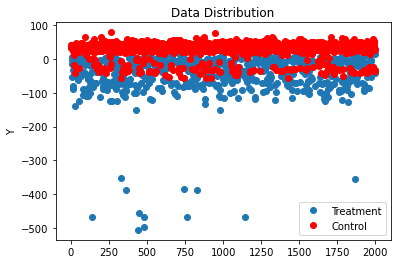

In [38]:
# High-dimensional
plotComposition(dataset)

**Naive estimate of ATE**

In [40]:
def naive_ATE(dataset):
    return np.average(dataset[dataset.A == 1].Y) - np.average(dataset[dataset.A == 0].Y)

In [41]:
print("Naive ATE for high-dimensional data:",naive_ATE(copy_dataset(highDim_dataset)))
print("Naive ATE for low-dimensional data:",naive_ATE(copy_dataset(lowDim_dataset)))

Naive ATE for high-dimensional data: -75.17133436876799
Naive ATE for low-dimensional data: 10.602068661915688


## Are the data sets balanced?

In [50]:
def checkComposition(dataset):
    print("The dataset contains:\n",len(dataset[dataset.A == 1]), "cases in Treatment group\n", 
          len(dataset[dataset.A == 0]), "cases in Control group.")
    print("Treatment/Control ratio: {}/100".format(round(len(dataset[dataset.A == 1])/len(dataset[dataset.A == 0])*100)))

In [51]:
print("High-dimensional")
checkComposition(copy_dataset(highDim_dataset))
print('-'*20)
print("Low-dimensional")
checkComposition(copy_dataset(lowDim_dataset))

High-dimensional
The dataset contains:
 643 cases in Treatment group
 1357 cases in Control group.
Treatment/Control ratio: 47/100
--------------------
Low-dimensional
The dataset contains:
 106 cases in Treatment group
 394 cases in Control group.
Treatment/Control ratio: 27/100


Thus in this case, the high-dimensional data is slightly imbalanced, but acceptable. However, the low-dimensional data displays severer imbalance between groups. In any cases, one can use oversampling or smote to balance the data, which however may not be beneficial for some ATE estimation algorithms. 

In [191]:
def Oversample(dataset):
    ovs = RandomOverSampler(random_state = RANDOM_STATE)
    x,y = ovs.fit_resample(dataset.loc[:, dataset.columns != 'A'], dataset.A)
    x.insert(1,"A",y)
    return x

In [190]:
def SMOTE(dataset):
    smk = SMOTETomek()
    x, y = smk.fit_resample(dataset.loc[:,dataset.columns != 'A'], dataset.A)
    x.insert(1,"A",y)
    return x


,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185
0,41.224513,0,0,1,4,18,17,-1,1,0.75,...,8,10,8,9,8,-1,-1,-1,-1,-1
1,40.513875,0,0,0,1,10,6,-1,10,0.35,...,6,5,6,8,5,-1,-1,-1,-1,-1
2,38.495476,0,0,0,16,8,4,4,4,0.40,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,33.001889,0,1,0,3,10,2,-1,5,0.41,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,37.043603,0,1,1,11,21,10,10,20,0.43,...,6,8,7,7,7,6,7,6,6,7


## Split into train and test set

In [180]:
def split_train_test(dataset, test_size=0.2):
    X = np.array(dataset.drop(['Y', 'A'], axis=1))
    y = np.array(dataset.Y)
    A = np.array(dataset.A)
    
    idx_train, idx_test, y_train, y_test = train_test_split(range(X.shape[0]), y, 
                                                            test_size=test_size, random_state=RANDOM_STATE)
    X_train = X[idx_train]
    X_test = X[idx_test]
    A_train = A[idx_train]
    A_test = A[idx_test]
    return X_train, X_test, y_train, y_test, A_train, A_test

## Propensity Score - Boosted Stumps

### Gradient Boosting

In [286]:
param_grid = {
              'learning_rate': [0.1,0.05],
              'max_depth': [1,2,5],
              'min_samples_split': [2,3,4],
              'n_estimators': [10,20,50],#,150],
              'min_samples_leaf':[1,3,5]
              }

In [153]:
def grid_search(X:np.array, A:np.array, model, param_grid=param_grid, cv=5, print_step = True, sample_weight=None):
    """
    Takes a baseline model and does grid search among parameters in the param_grid with cross validation.
    Returns the model with best hyparameters after searching
    """
    if sample_weight is None:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A)
    else:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A, sample_weight = sample_weight)
    print("Best accuracy: %0.3f" % (clf.best_score_))
    print()
    print("Best parameters: %r" % clf.best_params_)
    print('-'*30)
    if print_step:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        		print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print('-'*30)

    return(model.set_params(**clf.best_params_))

gbm = grid_search(X_train, A_train, model=GradientBoostingClassifier(random_state=RANDOM_STATE), print_step=False)

A copy of the best hyperparameters from grid search:

best_params = {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}

gbm = GradientBoostingClassifier(random_state=RANDOM_STATE).set_params(**best_params).fit(X_train, A_train,
                                                                                         sample_weight=sample_weights)

### Weighted XGBoost

In [208]:
param_grid_xgb = {
    'objective':['binary:logistic', 'reg:squarederror'],
    'n_estimators':[10, 50, 100],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1.0, 1.5],
    'subsample': [0.3, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'max_depth': [3, 4]
    #'scale_pos_weight':[1, 2, 4]
}

In [209]:
grid_search(X_train, A_train, param_grid = param_grid_xgb, print_step=False, cv=5,
                        model=XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE))

[04:29:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best accuracy: 0.713

Best parameters: {'colsample_bytree': 0.6, 'gamma': 1.0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 'objective': 'binary:logistic', 'subsample': 0.8}
------------------------------


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=1.0,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=-1, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.8, tree_method=None,
              validate_parameters=None, verbosity=None)

A copy of best hyperparameters from grid search

In [28]:
best_params_xgb = {'colsample_bytree': 0.8, 'gamma': 1.0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 
                        'objective': 'reg:squarederror', 'subsample': 0.8}

xgb = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb).fit(X_train, A_train)

In [29]:
print(xgb.score(X_train, A_train))
print(xgb.score(X_test, A_test))

0.76625
0.6725


In [41]:
propensity_score_xgb = xgb.predict(np.array(dataset.iloc[:, 2:]))

## Preparing data for ATE estimation

In [89]:
def combine_data(ps, A, y):
    """
    Combines propensity scores with A and y
    
    Returns a data frame with three columns
    """
    data_combined = pd.DataFrame(
        np.array([ps, A, y]).T,
        columns=['e', 'A', 'Y']
    )
    return data_combined

In [294]:
def data_preparation_pipeline(dataset, resample=None):
    """
    Each sampling method results in a different data size, a set of best 
    hyperparameters from grid search, and an array of sample weights. 
    This pipeline prepares a dataset, with the specified resampling method, 
    for the later ATE estimation.
    """
    test_scores = []
    params = []
    weights =[]

    if resample == None:
        data = dataset
    elif resample == 'over':
        data = Oversample(dataset)
    elif resample == 'smote':
        data = SMOTE(dataset)
    else:
        print("Error: Invalid resampling method! Possible ")
        
    # A copy of the best hyperparameter candidates from grid search:
    best_params0 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
    best_params1 =  {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
    best_params2 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
    best_params3 = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
    best_params4 = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
    params_list = [best_params0, best_params1, best_params2, best_params3, best_params4]
    
    X_train, X_test, y_train, y_test, A_train, A_test = split_train_test(data)
    
    for i in range(15,22):
        # high-dimensional weights (the best weights after multiple trials)
        sample_weights = np.zeros(len(A_train))
        sample_weights[A_train == 0] = i
        sample_weights[A_train == 1] = 20
        
        for p in params_list:
            gbm = GradientBoostingClassifier().set_params(**p).fit(X_train, A_train,sample_weight=sample_weights)
            #print(gbm.score(X_train, A_train), gbm.score(X_test, A_test))
            test_scores.append(gbm.score(X_test, A_test))
            params.append(p)
            weights.append(sample_weights)
        
    best_ = params[test_scores.index(max(test_scores))]
    gbm = GradientBoostingClassifier().set_params(**best_).fit(X_train, A_train,
                                                               sample_weight=weights[test_scores.index(max(test_scores))])
    print("Train accuracy: ",gbm.score(X_train, A_train))
    print("Test accuracy: ", gbm.score(X_test, A_test))
    propensity_score_gbm = np.exp(gbm.predict_log_proba(data.iloc[:, 2:]))[:, 1]
    
    data_for_ATE = combine_data(propensity_score_gbm, data.A, data.Y)
    X_data = data.drop(['Y', 'A'], axis=1)
    return data_for_ATE, X_data


plt.plot(data_for_ATE[data_for_ATE.A==0].e, 
         data_for_ATE[data_for_ATE.A==0].Y, 'o')
plt.plot(data_for_ATE[data_for_ATE.A==1].e, 
         data_for_ATE[data_for_ATE.A==1].Y, 'ro')
plt.xlabel("Propensity score")
plt.ylabel("Y")
plt.title("Outcome variable vs. Propensity score between groups")
plt.show()

## Calculating ATE

### ATE Estimate - Stratification

In [96]:
def Stratify(data:pd.DataFrame, k:int):
    
    data_copy = data.copy()
    
    # rank to resolve duplicate edge cases
    data_copy['bin'] = pd.qcut(
        data_copy.e.rank(method='first'), k, labels=False
    )
    
    return data_copy

Stratify(data_for_ATE, 5)

In [98]:
def Calculate_ATE_Strat(data:pd.DataFrame, k:int):
    
    n = data.shape[0]
    
    data_copy = Stratify(data, k)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_copy[data_copy.bin == k_idx]
        nj = Qj.shape[0]

        ATE += (nj/n) * ( np.average(Qj[Qj.A==1].Y) - np.average(Qj[Qj.A==0].Y) )
    
    return ATE

### ATE Estimate - Stratification and Regression Adjustment

In [199]:
def Calculate_ATE_StratRegrAdjusted_with_X(data:pd.DataFrame, X_data:pd.DataFrame, k:int):
    
    n = data.shape[0]
    
    data_adjusted = pd.concat(
        [Stratify(data, k), X_data.reset_index(drop=True)], axis=1)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_adjusted[data_adjusted.bin == k_idx]
        nj = Qj.shape[0]
 
        # Regression Adjusted Linearly, then Delta_j = alpha^Z_j
        X = Qj.drop(['e', 'Y', 'bin'], axis=1)
        y = Qj.Y
        reg = LinearRegression().fit(X, y)
        
        ATE += reg.coef_[0]
        
    return ATE / k

### ATE Estimate - Regression Adjustment

Adapting the last function with stratification and regression adjustment, we can simply obtain this by setting k = 1, which means one stratum, or no stratification.

## Result Summary

In [276]:
def estimation_summary(data:pd.DataFrame, data_X:pd.DataFrame, k:int, true_ATE=high_true_ATE, title="high"):
    """"""
    start = time.time()
    strat = Calculate_ATE_Strat(data, k)
    print("Time for calculating ATE with stratification: {}s".format(round(time.time()-start, 4)))
    start = time.time()
    regadj = Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, 1)
    print("Time for calculating ATE with regression adjustment: {}s".format(round(time.time()-start, 4)))
    start = time.time()
    combined = Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, k)
    print("Time for calculating ATE with stratification + regression adjustment: {}s".format(round(time.time()-start, 4)))
    print("Estimated ATE by stratification with k = {}: {}".format(k, strat))
    print("Estimated ATE by regression adjustment: {}".format(regadj))
    print("Estimated ATE by stratification + regression adjustment with k = {}: {}".format(k, combined))
    
    plt.figure(figsize=(10,6))
    plt.plot(range(1,11), [Calculate_ATE_Strat(data, i) for i in range(1, 11)], marker='o',
                label = 'ATE estimate by stratification')
    plt.plot(range(1,11), [Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, i) for i in range(1, 11)], marker='o',
                label = 'ATE estimate by strat + reg_adj')
    plt.scatter(1, regadj, s=150, label='ATE estimate by regression adjustment',alpha=1, marker='o',c='green')

    plt.hlines(true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
    #plt.hlines(naive_ATE(data), 1, 10, colors='grey', linestyles='dashed', label='ATE Naive')
    plt.title("The {}-dimensional dataset\nTrue ATE vs. Estimated ATE".format(title))
    plt.xlabel("Number of strata (k)")
    plt.ylabel("ATE")
    plt.legend()
    plt.show()
    return strat, regadj, combined

#### Result plots for high-dimensional dataset

In [295]:
dataset = copy_dataset(highDim_dataset, label='low')

Shape of the low-dimensional dataset: (2000, 187)


Train accuracy:  0.735625
Test accuracy:  0.745
Time for calculating ATE with stratification: 0.009s
Time for calculating ATE with regression adjustment: 0.029s
Time for calculating ATE with stratification + regression adjustment: 0.051s
Estimated ATE by stratification with k = 5: -55.59279960713291
Estimated ATE by regression adjustment: -59.365443691851674
Estimated ATE by stratification + regression adjustment with k = 5: -51.60840553378588


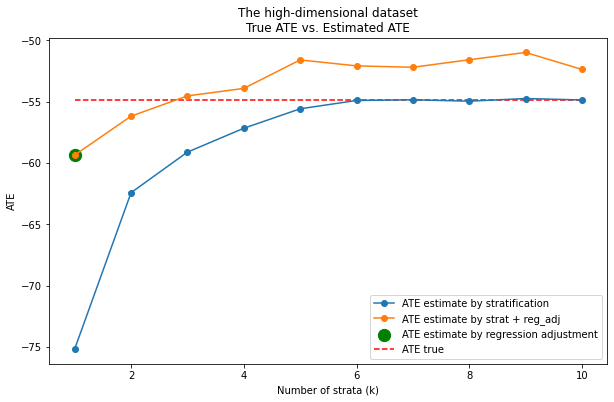

In [296]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample=None)
strat, regadj, combined = estimation_summary(data_for_ATE, X_data, k=5, true_ATE=high_true_ATE, title="high")

Train accuracy:  0.9557807461999078
Test accuracy:  0.7863720073664825
Time for calculating ATE with stratification: 0.008s
Time for calculating ATE with regression adjustment: 0.028s
Time for calculating ATE with stratification + regression adjustment: 0.053s
Estimated ATE by stratification with k = 5: -48.29465022833129
Estimated ATE by regression adjustment: -57.7743849810983
Estimated ATE by stratification + regression adjustment with k = 5: -52.14534180794649


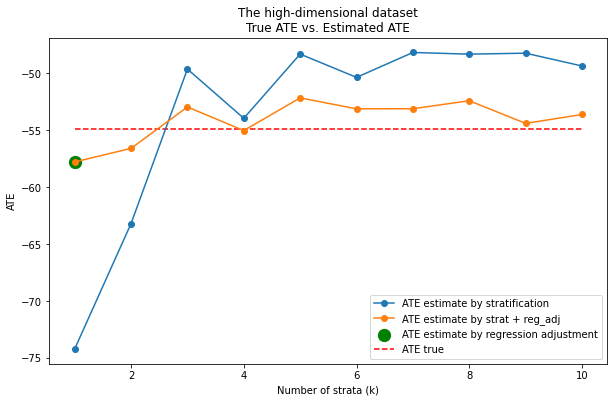

In [297]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample='over')
strat_ovr, regadj_ovr, combined_ovr = estimation_summary(data_for_ATE, X_data, k=5, true_ATE=high_true_ATE, title="high")

Time for calculating ATE with stratification: 0.012s
Time for calculating ATE with regression adjustment: 0.029s
Time for calculating ATE with stratification + regression adjustment: 0.06s
Estimated ATE by stratification with k = 5: -50.6001162246684
Estimated ATE by regression adjustment: -57.96179092860124
Estimated ATE by stratification + regression adjustment with k=5: -55.569101659359646


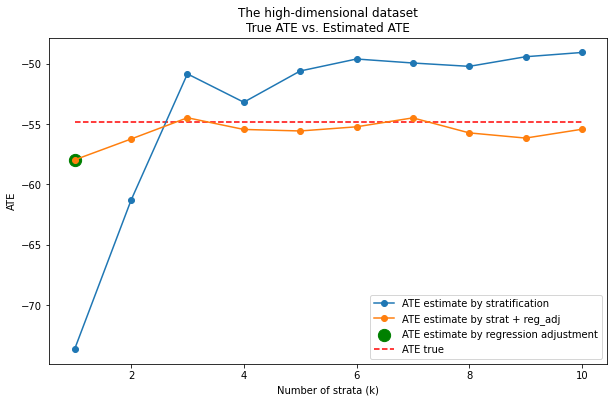

In [206]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample='smote')
strat_smt, regadj_smt, combined_smt = estimation_summary(data_for_ATE, X_data, k=5, true_ATE=high_true_ATE, title="high")

#### Result plots for low-dimensional dataset

In [298]:
dataset = copy_dataset(lowDim_dataset, label='low')

Shape of the low-dimensional dataset: (500, 24)


Train accuracy:  0.825
Test accuracy:  0.85
Time for calculating ATE with stratification: 0.008s
Time for calculating ATE with regression adjustment: 0.005s
Time for calculating ATE with stratification + regression adjustment: 0.014s
Estimated ATE by stratification with k = 5: 0.207079123866041
Estimated ATE by regression adjustment: 2.472655707042314
Estimated ATE by stratification + regression adjustment with k = 5: 1.8271129168311258


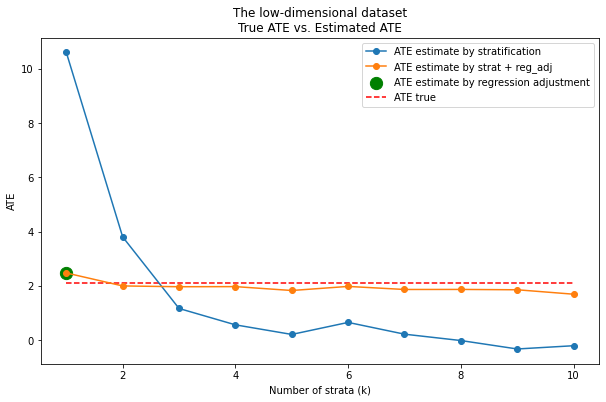

In [299]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample=None)
strat, regadj, combined = estimation_summary(data_for_ATE, X_data, k=5, true_ATE=low_true_ATE, title="low")

Train accuracy:  0.9761904761904762
Test accuracy:  0.8924050632911392
Time for calculating ATE with stratification: 0.009s
Time for calculating ATE with regression adjustment: 0.011s
Time for calculating ATE with stratification + regression adjustment: 0.017s
Estimated ATE by stratification with k = 5: nan
Estimated ATE by regression adjustment: 2.3467971898910025
Estimated ATE by stratification + regression adjustment with k = 5: 0.7076840600626533


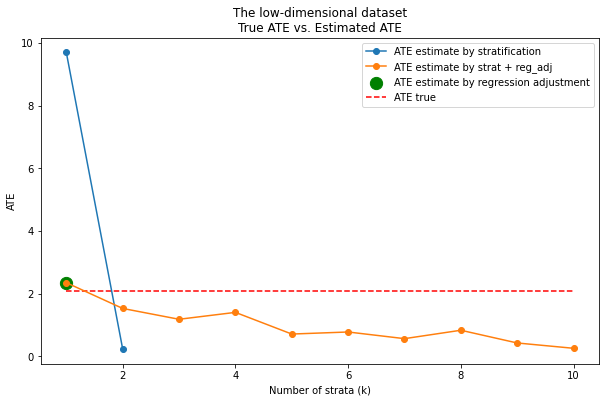

In [300]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample='over')
strat, regadj, combined = estimation_summary(data_for_ATE, X_data, k=5, true_ATE=low_true_ATE, title="low")

Train accuracy:  0.9852700490998363
Test accuracy:  0.7973856209150327
Time for calculating ATE with stratification: 0.009s
Time for calculating ATE with regression adjustment: 0.005s
Time for calculating ATE with stratification + regression adjustment: 0.015s
Estimated ATE by stratification with k = 5: nan
Estimated ATE by regression adjustment: 2.354734965058734
Estimated ATE by stratification + regression adjustment with k = 5: 2.0855027260709127


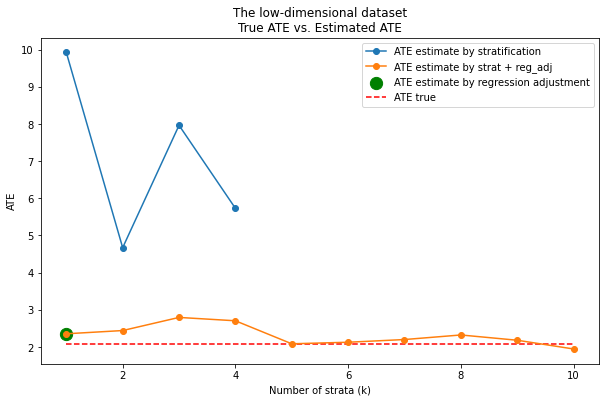

In [301]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample='smote')
strat, regadj, combined = estimation_summary(data_for_ATE, X_data, k=5, true_ATE=low_true_ATE, title="low")

## Conclusion and recommendations

Among three algorithms, **stratification** has the lowest time complexity and **stratification with regression adjustment** has the highest time complexity.

Considering the estimation accuracy, for the high-dimensional dataset, **stratification** achieves the best ATE estimate closest to the true ATE by setting k = 5